In [1]:
from environment import Environment
from discreteAgent import Agent
from discreteTrainer import Final_variational_trainer, Q_learning_trainer
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
import json
from easydict import EasyDict
from datetime import date
import os
import torch

# Environment Params

In [3]:
args = EasyDict()
args.ENV_NAME = 'Bottleneck' #'Pendulum-v0' #'CartPole-v1' #'MountainCar-v0' #'FrozenLake-v0' #
args.continuous=False

In [4]:
env = Environment.bottleneck(initial_state_range=0)

In [5]:
env.N_obs

18

# Trainer Params

In [6]:
args.monte_carlo=True
args.augmentation = True
args.final = True 

In [7]:
ALPHA_REF = 0.01 # le alpha qui sert à apprendre Q_ref (PREC inclus)
BETA_REF = 100 # amplification du reward

args.PREC = 3 / BETA_REF  # poids relatif des 2 termes dans la mise à jour explo/exploit
args.Q_VAR_MULT = 1

args.ALPHA = ALPHA_REF / args.Q_VAR_MULT / args.PREC  # la division par PREC assure la même "vitesse d'app"
                                                      # quelle que soit la valeur de PREC


args.OBS_LEAK = args.ALPHA / env.N_obs #1e-3  #3e-3 
# OBS_LEAK regule la valeur de KL (si faible : atténue les pics pour les etats 'nouveaux', favorise le 'turn over')



In [8]:
args.ALPHA, args.PREC, args.OBS_LEAK

(0.33333333333333337, 0.03, 0.01851851851851852)

# Agent Params

In [9]:
args.isTime = True
args.offPolicy = False
args.BETA = BETA_REF 

args.GAMMA = 1
args.do_reward = None
args.HIST_HORIZON = 200 * int(1/args.OBS_LEAK)

args.act_renorm = False
args.retain_present = False
args.retain_trajectory = False

args.KL_centering = True
args.rtg_centering = True

# Data path

In [10]:
data_path = "data/{}/{}-{}".format(args.ENV_NAME,str(date.today()),args.ENV_NAME)
if not args.final:
    data_path += '-full'
else:
    data_path += '-final'
if args.do_reward:
    data_path += '-do-reward'
else:
    data_path += '-no-reward'

data_path += '-LEAK-{}'.format(args.OBS_LEAK)
data_path += '-GAMMA-{}'.format(args.GAMMA)
data_path += '-BETA-{}'.format(args.BETA)
data_path += '-PREC-{}'.format(args.PREC)
data_path += '-ALPHA-{}'.format(ALPHA_REF)



In [11]:
data_path_npy = data_path+'.npy'
data_path_json = data_path+'.json'

In [12]:
if not os.path.isfile(data_path_json):
    with open(data_path_json, 'w') as fp:
        json.dump(args, fp)

In [13]:
data_path_npy

'data/Bottleneck/2021-04-26-Bottleneck-final-no-reward-LEAK-0.01851851851851852-GAMMA-1-BETA-100-PREC-0.03-ALPHA-0.01.npy'

In [14]:
N = 3000 # Number of episodes
NB_TRIALS = 1

In [15]:
args.do_reward = True #False  #
verbose = True

In [16]:
mem_Q_var = []
mem_Q_ref = []
BETA= args.BETA
agent = Agent(env,
              ALPHA=args.ALPHA,
              GAMMA=args.GAMMA, # Episodic agent!
              BETA=BETA, 
              PREC=args.PREC,
              do_reward=args.do_reward,
              isTime=args.isTime,    #!! TimeAgent
              offPolicy=False) 

In [17]:
trainer = Final_variational_trainer(agent, 
                                    monte_carlo=args.monte_carlo, 
                                    final= args.final,
                                    augmentation=args.augmentation,
                                    OBS_LEAK=args.OBS_LEAK,
                                    ref_prob='unif',
                                    KL_centering=args.KL_centering,
                                    rtg_centering=args.rtg_centering) #[2,5] # 

In [18]:
mem_total_reward = {}
nb_visits_final = {}

In [19]:
for trial in range(N):

    trainer.run_episode(verbose=verbose)
    mem_Q_var.append(np.array(agent.Q_var_tab))
    mem_Q_ref.append(np.array(agent.Q_ref_tab))     

    if True: #trial%100 == 0:
        print(trial)
        print("Trajectory: ", trainer.trajectory)
        print("Total reward got: %.4f" % trainer.total_reward)
        obs = env.state
        print(np.mean(trainer.obs_score), trainer.obs_score[obs])
        
    mem_total_reward[trial] = trainer.mem_total_reward
    nb_visits_final[trial] = trainer.nb_visits_final


/home/dauce/Recherche/scripts/VariationalRL/discreteTrainer.py:80: RuntimeWarning: divide by zero encountered in long_scalars
  p[np.where(self.nb_visits_final > 0)] = 1 / np.sum(self.nb_visits_final > 0)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


obs: 6 final KL loss: 0.0
Time elapsed : 0.008322999999999858
0
Trajectory:  [0, 6, 0, 0, 0, 6, 0, 6]
Total reward got: 0.0000
0.36793855755907906 2.8572135581880005
obs: 13 final KL loss: 0.009302392662313586
Time elapsed : 0.0024920000000001608
1
Trajectory:  [0, 1, 7, 8, 14, 8, 7, 13]
Total reward got: 0.0000
0.690750854405273 1.0
obs: 0 final KL loss: 0.018575671124173798
Time elapsed : 0.0022369999999996004
2
Trajectory:  [0, 1, 7, 6, 0, 0, 1, 0]
Total reward got: 0.0000
0.9739714542968263 5.807404274234152
obs: 12 final KL loss: 0.027819837928367175
Time elapsed : 0.00247099999999989
3
Trajectory:  [0, 0, 1, 1, 0, 6, 12, 12]
Total reward got: 0.0000
1.2224561278566748 1.9814814814814814
obs: 6 final KL loss: 0.47035288881942416
Time elapsed : 0.003127000000000102
4
Trajectory:  [0, 0, 0, 0, 1, 0, 0, 6]
Total reward got: 0.0000
1.440465103961473 4.252396523269882
obs: 0 final KL loss: 0.3062577435759546
Time elapsed : 0.0022529999999996164
5
Trajectory:  [0, 0, 0, 0, 0, 0, 0, 0]
T

obs: 1 final KL loss: 0.7824339744253659
Time elapsed : 0.001843000000000039
84
Trajectory:  [0, 6, 6, 6, 7, 8, 2, 1]
Total reward got: 0.0000
2.9999556415285387 6.244314676945876
obs: 5 final KL loss: -1.0573111025631023
Time elapsed : 0.00626799999999994
85
Trajectory:  [0, 1, 2, 8, 9, 3, 4, 5]
Total reward got: 0.0000
2.9999610819258744 1.0
obs: 7 final KL loss: 0.5145708555409843
Time elapsed : 0.003122999999999987
86
Trajectory:  [0, 0, 6, 12, 12, 6, 6, 7]
Total reward got: 0.0000
2.9999658550792274 6.663259371450708
obs: 16 final KL loss: -1.0019260701566561
Time elapsed : 0.00411000000000028
87
Trajectory:  [0, 0, 1, 2, 8, 9, 15, 16]
Total reward got: 0.0000
2.9999700428235268 1.0
obs: 2 final KL loss: 0.9325935259859812
Time elapsed : 0.003566999999999876
88
Trajectory:  [0, 0, 1, 2, 8, 2, 2, 2]
Total reward got: 0.0000
2.9999737169569607 7.791175809075956
obs: 14 final KL loss: 0.8280592323814853
Time elapsed : 0.005119000000000096
89
Trajectory:  [0, 0, 1, 7, 13, 13, 14, 14]


obs: 14 final KL loss: 0.7590220543120609
Time elapsed : 0.0029400000000001647
159
Trajectory:  [0, 1, 0, 1, 2, 8, 14, 14]
Total reward got: 0.0000
2.999999997572924 3.675406272704556
obs: 7 final KL loss: 0.1896367811577897
Time elapsed : 0.0021140000000001713
160
Trajectory:  [0, 0, 1, 7, 6, 0, 6, 7]
Total reward got: 0.0000
2.9999999978705962 7.471769767924739
obs: 14 final KL loss: 0.8608548994246181
Time elapsed : 0.0015659999999999563
161
Trajectory:  [0, 6, 0, 1, 1, 7, 8, 14]
Total reward got: 0.0000
2.9999999981317598 3.829142931652167
obs: 6 final KL loss: 0.8140499384383024
Time elapsed : 0.0015570000000000306
162
Trajectory:  [0, 0, 0, 0, 0, 0, 6, 6]
Total reward got: 0.0000
2.9999999983608934 9.171377246964619
obs: 1 final KL loss: 0.7273604062977665
Time elapsed : 0.0017979999999999663
163
Trajectory:  [0, 0, 0, 1, 7, 6, 7, 1]
Total reward got: 0.0000
2.999999998561924 9.300738115474823
obs: 12 final KL loss: 0.31389747332366236
Time elapsed : 0.005513999999999797
164
Traj

obs: 1 final KL loss: -0.10075705091782261
Time elapsed : 0.0024860000000002103
241
Trajectory:  [0, 0, 0, 6, 7, 1, 7, 1]
Total reward got: 0.0000
2.9999999999999516 8.199795635944206
obs: 8 final KL loss: 0.3378022798319975
Time elapsed : 0.002325999999999606
242
Trajectory:  [0, 1, 7, 1, 2, 8, 7, 8]
Total reward got: 0.0000
2.9999999999999583 4.230543124886227
obs: 14 final KL loss: 1.30169799931303
Time elapsed : 0.0020340000000000913
243
Trajectory:  [0, 1, 1, 2, 8, 7, 13, 14]
Total reward got: 0.0000
2.9999999999999636 7.702532493926976
obs: 9 final KL loss: -0.6256518855782671
Time elapsed : 0.0017520000000001978
244
Trajectory:  [0, 1, 1, 7, 8, 9, 10, 9]
Total reward got: 0.0000
2.9999999999999685 2.2781565248303215
obs: 13 final KL loss: 0.6400200709057846
Time elapsed : 0.004927000000000348
245
Trajectory:  [0, 0, 0, 6, 7, 13, 14, 13]
Total reward got: 0.0000
2.999999999999973 4.891530924394801
obs: 14 final KL loss: 1.3326432127311467
Time elapsed : 0.0023980000000003443
246


obs: 2 final KL loss: 0.3896904221813746
Time elapsed : 0.0021020000000002703
322
Trajectory:  [0, 1, 2, 2, 2, 2, 1, 2]
Total reward got: 0.0000
3.000000000000004 10.806881822091754
obs: 14 final KL loss: 0.4586159814109849
Time elapsed : 0.002054999999999918
323
Trajectory:  [0, 1, 7, 13, 14, 14, 14, 14]
Total reward got: 0.0000
3.0000000000000044 6.932080989265366
obs: 16 final KL loss: -0.384043121767216
Time elapsed : 0.00379800000000019
324
Trajectory:  [0, 1, 2, 8, 9, 15, 15, 16]
Total reward got: 0.0000
3.000000000000004 1.6266957855262958
obs: 3 final KL loss: 0.9150768274992263
Time elapsed : 0.003563000000000205
325
Trajectory:  [0, 1, 2, 8, 9, 10, 9, 3]
Total reward got: 0.0000
3.0000000000000044 3.3445816661172825
obs: 4 final KL loss: 0.26243087778072427
Time elapsed : 0.0027810000000001445
326
Trajectory:  [0, 1, 2, 8, 9, 3, 3, 4]
Total reward got: 0.0000
3.000000000000005 1.4001239494332716
obs: 4 final KL loss: 0.46465138598223454
Time elapsed : 0.004066000000000347
327

401
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000004 8.148812428613747
obs: 17 final KL loss: 2.486150186485585
Time elapsed : 0.001942999999999806
402
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000004 8.149391665012534
obs: 17 final KL loss: 2.495337440083295
Time elapsed : 0.003814999999999902
403
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000004 8.149899860276303
obs: 17 final KL loss: 2.504273046570613
Time elapsed : 0.0023489999999997124
404
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000004 8.150345727329304
obs: 17 final KL loss: 2.512966049842881
Time elapsed : 0.003394999999999815
405
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000004 8.150736910488856
obs: 17 final KL loss: 2.5214250550929345
Time elapsed : 0.002914000000000083
406
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.00000000000

obs: 2 final KL loss: -0.027729995121959394
Time elapsed : 0.0021379999999999733
477
Trajectory:  [0, 1, 2, 8, 2, 2, 2, 2]
Total reward got: 0.0000
3.000000000000005 13.933982717647933
obs: 13 final KL loss: -0.43902446335171286
Time elapsed : 0.0018529999999996605
478
Trajectory:  [0, 1, 7, 13, 14, 14, 13, 13]
Total reward got: 0.0000
3.000000000000005 3.400937167032287
obs: 17 final KL loss: 2.4087964458229307
Time elapsed : 0.0022289999999998145
479
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 3.1637602325505196
obs: 16 final KL loss: 0.06294603447657776
Time elapsed : 0.00239900000000004
480
Trajectory:  [0, 1, 2, 8, 9, 15, 15, 16]
Total reward got: 0.0000
3.0000000000000044 4.517302994048018
obs: 15 final KL loss: 0.03201790323720077
Time elapsed : 0.0017999999999998018
481
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 15]
Total reward got: 0.0000
3.0000000000000044 7.399299242577309
obs: 17 final KL loss: 2.3839282183556483
Time elapsed : 0.002666000

obs: 12 final KL loss: 0.6565708452291581
Time elapsed : 0.0026580000000002713
560
Trajectory:  [0, 1, 7, 6, 7, 13, 12, 12]
Total reward got: 0.0000
3.0000000000000044 5.959438098036238
obs: 2 final KL loss: 0.7477746231479858
Time elapsed : 0.0027119999999998257
561
Trajectory:  [0, 0, 1, 7, 1, 2, 8, 2]
Total reward got: 0.0000
3.0000000000000044 7.295949653182756
obs: 3 final KL loss: -0.0978109574864714
Time elapsed : 0.002010999999999985
562
Trajectory:  [0, 0, 1, 1, 2, 8, 9, 3]
Total reward got: 0.0000
3.000000000000005 1.4124911423105249
obs: 13 final KL loss: 0.38599019062372797
Time elapsed : 0.002162999999999915
563
Trajectory:  [0, 0, 0, 6, 12, 6, 12, 13]
Total reward got: 0.0000
3.000000000000004 3.5674567172203027
obs: 3 final KL loss: 0.18804387401811562
Time elapsed : 0.0035969999999996283
564
Trajectory:  [0, 1, 2, 8, 14, 8, 9, 3]
Total reward got: 0.0000
3.0000000000000044 2.087264654513567
obs: 12 final KL loss: 0.7369072471927955
Time elapsed : 0.0022560000000000358
5

obs: 6 final KL loss: 0.31846236321609345
Time elapsed : 0.00200699999999987
643
Trajectory:  [0, 1, 7, 13, 12, 6, 0, 6]
Total reward got: 0.0000
3.000000000000005 10.205662407651522
obs: 12 final KL loss: 0.2494083039541688
Time elapsed : 0.0016899999999999693
644
Trajectory:  [0, 1, 7, 1, 7, 13, 12, 12]
Total reward got: 0.0000
3.000000000000005 4.873425678337174
obs: 1 final KL loss: 0.40326333558422345
Time elapsed : 0.001218999999999859
645
Trajectory:  [0, 0, 0, 6, 6, 6, 0, 1]
Total reward got: 0.0000
3.000000000000005 7.730908818571608
obs: 6 final KL loss: 0.4906410725019481
Time elapsed : 0.0027340000000002362
646
Trajectory:  [0, 0, 6, 0, 0, 0, 6, 6]
Total reward got: 0.0000
3.000000000000005 12.27339325433777
obs: 9 final KL loss: -0.9684165909187756
Time elapsed : 0.0022380000000001843
647
Trajectory:  [0, 6, 0, 0, 1, 2, 8, 9]
Total reward got: 0.0000
3.000000000000005 1.2836372849615987
obs: 9 final KL loss: -0.34815750889866903
Time elapsed : 0.002222999999999864
648
Traj

obs: 17 final KL loss: 2.3854321455401335
Time elapsed : 0.002074999999999605
729
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 8.136794347473586
obs: 17 final KL loss: 2.397523311633163
Time elapsed : 0.0031840000000000757
730
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 8.138847555685487
obs: 17 final KL loss: 2.409250082398552
Time elapsed : 0.0026279999999996306
731
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 8.14064894574144
obs: 17 final KL loss: 2.4206274990437007
Time elapsed : 0.0012710000000000221
732
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 8.142229402177794
obs: 17 final KL loss: 2.431669747671172
Time elapsed : 0.0011630000000000251
733
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 8.143616021660321
obs: 17 final KL loss: 2.442390222581496
Time elapsed : 0.001152000000000264
7

obs: 14 final KL loss: 0.02843723160655154
Time elapsed : 0.0020559999999996137
816
Trajectory:  [0, 0, 1, 7, 8, 14, 14, 14]
Total reward got: 0.0000
3.0000000000000053 3.581846613152391
obs: 10 final KL loss: 0.13744995702041551
Time elapsed : 0.0028279999999991645
817
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 10]
Total reward got: 0.0000
3.000000000000005 2.195187885302183
obs: 17 final KL loss: 2.690469483340958
Time elapsed : 0.003098999999999741
818
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000004 5.268811496920324
obs: 17 final KL loss: 2.694558951733565
Time elapsed : 0.0026729999999997034
819
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 5.622611862844472
obs: 17 final KL loss: 2.6985564925228793
Time elapsed : 0.0021589999999998
820
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000004 5.933019963334619
obs: 17 final KL loss: 2.7024645266637686
Time elapsed : 0.002124000000000237


Time elapsed : 0.0025610000000000355
894
Trajectory:  [0, 0, 1, 7, 13, 14, 14, 13]
Total reward got: 0.0000
3.000000000000005 5.044240423208058
obs: 1 final KL loss: 0.3620261812313652
Time elapsed : 0.0020879999999996457
895
Trajectory:  [0, 0, 1, 1, 0, 1, 2, 1]
Total reward got: 0.0000
3.000000000000005 10.515120857264767
obs: 2 final KL loss: 0.768263147141361
Time elapsed : 0.0033289999999999154
896
Trajectory:  [0, 1, 2, 2, 2, 1, 2, 2]
Total reward got: 0.0000
3.0000000000000053 10.652657427089668
obs: 8 final KL loss: -0.2935097002435203
Time elapsed : 0.004355000000000331
897
Trajectory:  [0, 6, 12, 13, 14, 14, 14, 8]
Total reward got: 0.0000
3.000000000000005 5.596409900028533
obs: 14 final KL loss: 0.7883806700333436
Time elapsed : 0.00279100000000021
898
Trajectory:  [0, 0, 0, 6, 7, 8, 14, 14]
Total reward got: 0.0000
3.0000000000000053 6.625921495059405
obs: 1 final KL loss: 0.5104861063809922
Time elapsed : 0.002489999999999881
899
Trajectory:  [0, 0, 1, 1, 2, 2, 2, 1]
Tota

obs: 15 final KL loss: -0.159571350421015
Time elapsed : 0.002163000000000359
977
Trajectory:  [0, 1, 2, 8, 9, 10, 16, 15]
Total reward got: 0.0000
3.000000000000005 1.0019055103302783
obs: 2 final KL loss: 0.3345812951441318
Time elapsed : 0.0038759999999999906
978
Trajectory:  [0, 1, 1, 0, 0, 1, 2, 2]
Total reward got: 0.0000
3.000000000000005 3.4830148216023162
obs: 3 final KL loss: -0.08626330214149602
Time elapsed : 0.002494999999999692
979
Trajectory:  [0, 1, 7, 13, 14, 8, 9, 3]
Total reward got: 0.0000
3.000000000000005 1.2642362179884679
obs: 12 final KL loss: 0.7272331425205438
Time elapsed : 0.0019010000000001526
980
Trajectory:  [0, 1, 1, 7, 1, 7, 13, 12]
Total reward got: 0.0000
3.0000000000000053 6.186220430774016
obs: 12 final KL loss: 0.8605070275117681
Time elapsed : 0.002627000000000379
981
Trajectory:  [0, 0, 0, 6, 12, 12, 12, 12]
Total reward got: 0.0000
3.0000000000000053 9.317758370436962
obs: 8 final KL loss: 0.08182585655252783
Time elapsed : 0.002619999999999400

obs: 13 final KL loss: 0.6186495098072946
Time elapsed : 0.0020579999999998932
1060
Trajectory:  [0, 1, 7, 13, 14, 14, 13, 13]
Total reward got: 0.0000
3.000000000000005 6.482284457605158
obs: 8 final KL loss: 0.7560535441778016
Time elapsed : 0.0022299999999999542
1061
Trajectory:  [0, 1, 7, 8, 7, 13, 14, 8]
Total reward got: 0.0000
3.0000000000000044 5.611429526214531
obs: 8 final KL loss: 0.8853142055179801
Time elapsed : 0.002582999999999558
1062
Trajectory:  [0, 1, 2, 8, 9, 15, 9, 8]
Total reward got: 0.0000
3.0000000000000044 6.851167351708979
obs: 7 final KL loss: 0.7495114862077235
Time elapsed : 0.0028689999999995663
1063
Trajectory:  [0, 1, 7, 13, 14, 14, 13, 7]
Total reward got: 0.0000
3.000000000000005 7.736677361114875
obs: 14 final KL loss: 0.27733872855251507
Time elapsed : 0.0021810000000002105
1064
Trajectory:  [0, 0, 1, 7, 8, 14, 14, 14]
Total reward got: 0.0000
3.000000000000004 9.745372522155437
obs: 7 final KL loss: 0.8635884221507233
Time elapsed : 0.0014060000000

1140
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 7.636798842799518
obs: 17 final KL loss: 1.8404666069137081
Time elapsed : 0.002124000000000237
1141
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 7.700174592603353
obs: 17 final KL loss: 1.8742842183432409
Time elapsed : 0.002155000000000129
1142
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 7.7557775484181715
obs: 17 final KL loss: 1.9063993682407143
Time elapsed : 0.002361999999999753
1143
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 7.804561013780149
obs: 17 final KL loss: 1.9369476403685173
Time elapsed : 0.005066000000000237
1144
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 7.847361373182787
obs: 17 final KL loss: 1.9660492832809795
Time elapsed : 0.0027570000000007866
1145
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000


obs: 17 final KL loss: 2.7328824040019835
Time elapsed : 0.002918000000000198
1221
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000004 8.153522357893479
obs: 17 final KL loss: 2.7360360980242704
Time elapsed : 0.0023559999999998027
1222
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000004 8.153523939430471
obs: 17 final KL loss: 2.739121749108194
Time elapsed : 0.003881999999999941
1223
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 8.153525326997984
obs: 17 final KL loss: 2.7421410282318774
Time elapsed : 0.0028319999999997236
1224
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 8.153526544385633
obs: 10 final KL loss: -0.4352612081269269
Time elapsed : 0.001930999999999905
1225
Trajectory:  [0, 1, 2, 8, 9, 15, 9, 10]
Total reward got: 0.0000
3.0000000000000044 1.0000041855867923
obs: 17 final KL loss: 2.7268073808798845
Time elapsed : 0.00213200000

obs: 11 final KL loss: -1.0986120237817456
Time elapsed : 0.0023200000000000998
1301
Trajectory:  [0, 1, 2, 8, 9, 10, 11, 11]
Total reward got: 0.0000
3.000000000000005 1.9814814814814814
obs: 5 final KL loss: -0.7512044867769125
Time elapsed : 0.0035730000000002704
1302
Trajectory:  [0, 1, 2, 8, 9, 3, 4, 5]
Total reward got: 0.0000
3.0000000000000044 1.0021340968113286
obs: 15 final KL loss: -0.15482966615072558
Time elapsed : 0.001986999999999739
1303
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 15]
Total reward got: 0.0000
3.0000000000000044 7.787840056732959
obs: 17 final KL loss: 2.4866493829532947
Time elapsed : 0.0019489999999997565
1304
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 3.8546698059571143
obs: 17 final KL loss: 2.4958181135480415
Time elapsed : 0.002610999999999919
1305
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 4.381909256533649
obs: 16 final KL loss: 0.45519407268560963
Time elapsed : 0.002837

obs: 17 final KL loss: 2.719633162498977
Time elapsed : 0.0022050000000000125
1384
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 8.088554766924723
obs: 17 final KL loss: 2.723075022043662
Time elapsed : 0.0035689999999997113
1385
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 8.096524375698094
obs: 17 final KL loss: 2.726441663101855
Time elapsed : 0.0019839999999993196
1386
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 8.103516542352668
obs: 17 final KL loss: 2.729734974096227
Time elapsed : 0.002138999999999669
1387
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 8.10965114643621
obs: 17 final KL loss: 2.732956785551594
Time elapsed : 0.0034280000000004307
1388
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 8.11503336472719
obs: 17 final KL loss: 2.7361088723259304
Time elapsed : 0.00289699999999992

obs: 14 final KL loss: 0.663212411724587
Time elapsed : 0.0021820000000003503
1468
Trajectory:  [0, 1, 0, 6, 7, 13, 14, 14]
Total reward got: 0.0000
3.000000000000005 6.830504599961347
obs: 6 final KL loss: -1.0959720392539616
Time elapsed : 0.0020519999999999428
1469
Trajectory:  [0, 1, 7, 1, 2, 8, 7, 6]
Total reward got: 0.0000
3.000000000000005 1.8141477136375075
obs: 17 final KL loss: 2.577300359307174
Time elapsed : 0.005442999999999643
1470
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 4.836713931680719
obs: 15 final KL loss: -0.48672856087692695
Time elapsed : 0.002430999999999628
1471
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 15]
Total reward got: 0.0000
3.000000000000005 6.112297985179044
obs: 17 final KL loss: 2.5658674312285807
Time elapsed : 0.002679000000000542
1472
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 4.723059171406607
obs: 17 final KL loss: 2.572941329680186
Time elapsed : 0.00282999999999944

obs: 14 final KL loss: 0.6024750868293034
Time elapsed : 0.0022060000000001523
1552
Trajectory:  [0, 6, 7, 13, 14, 14, 14, 14]
Total reward got: 0.0000
3.000000000000005 7.435997729419315
obs: 6 final KL loss: -0.9091776147686836
Time elapsed : 0.004584999999999617
1553
Trajectory:  [0, 1, 7, 6, 12, 12, 6, 6]
Total reward got: 0.0000
3.0000000000000053 4.5627639208343505
obs: 0 final KL loss: 0.06110201574393859
Time elapsed : 0.0026340000000004693
1554
Trajectory:  [0, 0, 0, 0, 0, 6, 0, 0]
Total reward got: 0.0000
3.0000000000000044 9.105519682242676
obs: 2 final KL loss: 0.12388796451812745
Time elapsed : 0.0029609999999999914
1555
Trajectory:  [0, 1, 2, 2, 2, 2, 2, 2]
Total reward got: 0.0000
3.0000000000000044 11.631053799572568
obs: 2 final KL loss: 0.36759810241580704
Time elapsed : 0.0025760000000003558
1556
Trajectory:  [0, 1, 7, 1, 2, 8, 2, 2]
Total reward got: 0.0000
3.000000000000005 13.131497795456005
obs: 8 final KL loss: 0.5325830274530281
Time elapsed : 0.002653999999999

obs: 17 final KL loss: 2.379458489516214
Time elapsed : 0.0036650000000006955
1633
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 8.119762471761693
obs: 17 final KL loss: 2.3917312543134486
Time elapsed : 0.0034039999999997406
1634
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 8.123904574567582
obs: 17 final KL loss: 2.40363203535762
Time elapsed : 0.0026650000000003615
1635
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 8.127538664262918
obs: 17 final KL loss: 2.415176311230727
Time elapsed : 0.002657999999999383
1636
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 8.130727046718071
obs: 17 final KL loss: 2.4263786725835357
Time elapsed : 0.0017569999999995645
1637
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 8.13352438622606
obs: 17 final KL loss: 2.437252888463339
Time elapsed : 0.00368200000000040

1716
Trajectory:  [0, 1, 2, 8, 9, 15, 9, 8]
Total reward got: 0.0000
3.000000000000005 8.374535945450999
obs: 17 final KL loss: 2.6185834659432383
Time elapsed : 0.001924000000000703
1717
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 4.070145252513049
obs: 10 final KL loss: 0.2031681157210632
Time elapsed : 0.003753999999999813
1718
Trajectory:  [0, 1, 2, 2, 2, 8, 9, 10]
Total reward got: 0.0000
3.0000000000000053 1.4923895594993752
obs: 17 final KL loss: 2.606113963541253
Time elapsed : 0.002906999999999549
1719
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 4.132993148937399
obs: 14 final KL loss: 0.24708711556636764
Time elapsed : 0.0033929999999999794
1720
Trajectory:  [0, 1, 7, 6, 7, 13, 14, 14]
Total reward got: 0.0000
3.000000000000005 5.899176110503627
obs: 10 final KL loss: 0.39997911527659635
Time elapsed : 0.0028600000000000847
1721
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 10]
Total reward got: 0.0000
3.

obs: 11 final KL loss: 0.18863674519439577
Time elapsed : 0.002088000000000534
1797
Trajectory:  [0, 1, 2, 8, 9, 10, 11, 11]
Total reward got: 0.0000
3.000000000000004 3.588971738734768
obs: 17 final KL loss: 2.3266806755721037
Time elapsed : 0.0018120000000001468
1798
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 3.579316825459514
obs: 2 final KL loss: -0.43820195720747845
Time elapsed : 0.0014940000000001064
1799
Trajectory:  [0, 1, 2, 2, 2, 2, 2, 2]
Total reward got: 0.0000
3.0000000000000044 14.64309307747202
obs: 5 final KL loss: -0.2594356272091285
Time elapsed : 0.0023220000000003793
1800
Trajectory:  [0, 1, 2, 8, 9, 3, 4, 5]
Total reward got: 0.0000
3.0000000000000044 1.0037300525070827
obs: 10 final KL loss: 1.0459219788731584
Time elapsed : 0.0025120000000002918
1801
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 10]
Total reward got: 0.0000
3.000000000000004 3.4595769027394474
obs: 15 final KL loss: 0.25979005726849813
Time elapsed : 0.0022060000

obs: 17 final KL loss: 2.655042404526629
Time elapsed : 0.002102999999999966
1878
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 8.11968833294578
obs: 17 final KL loss: 2.659943807065425
Time elapsed : 0.004698999999999565
1879
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 8.123839528594662
obs: 17 final KL loss: 2.6647311948473362
Time elapsed : 0.0022890000000002075
1880
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 8.12748159593048
obs: 17 final KL loss: 2.6694077457694245
Time elapsed : 0.002601999999999549
1881
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 8.13067697759894
obs: 17 final KL loss: 2.6739765252587304
Time elapsed : 0.0022140000000003823
1882
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 8.13348045789342
obs: 17 final KL loss: 2.6784404913664797
Time elapsed : 0.0024639999999997997

obs: 17 final KL loss: 2.607772456928922
Time elapsed : 0.002324000000000659
1961
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 5.904189698472405
obs: 17 final KL loss: 2.613801900626803
Time elapsed : 0.0020289999999993924
1962
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 6.180063351402035
obs: 17 final KL loss: 2.6196845465391227
Time elapsed : 0.0041739999999999
1963
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 6.4221021530225055
obs: 17 final KL loss: 2.6254247986591537
Time elapsed : 0.0023849999999994154
1964
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 6.634455818795788
obs: 17 final KL loss: 2.631026889505723
Time elapsed : 0.0029000000000003467
1965
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 6.820765117410069
obs: 3 final KL loss: -1.0952023644820637
Time elapsed : 0.0025900000000

2037
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 6.947676410961437
obs: 17 final KL loss: 2.6350553793963187
Time elapsed : 0.0021460000000006474
2038
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 7.095570398615975
obs: 17 final KL loss: 2.6404274049307603
Time elapsed : 0.0035239999999996385
2039
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 7.22532575277409
obs: 14 final KL loss: 0.015610460077503774
Time elapsed : 0.002842999999999485
2040
Trajectory:  [0, 1, 1, 7, 8, 14, 14, 14]
Total reward got: 0.0000
3.0000000000000044 2.949905753091792
obs: 17 final KL loss: 2.6274260765484603
Time elapsed : 0.0029490000000000904
2041
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 6.561692440412383
obs: 17 final KL loss: 2.632980180615658
Time elapsed : 0.002010999999999541
2042
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000

obs: 17 final KL loss: 2.7161437013516587
Time elapsed : 0.0023210000000002395
2121
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 7.485657191093596
obs: 17 final KL loss: 2.7196620786105354
Time elapsed : 0.002728999999998649
2122
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 7.567569888002688
obs: 14 final KL loss: -0.6003695614002966
Time elapsed : 0.003181999999998908
2123
Trajectory:  [0, 1, 1, 7, 8, 14, 14, 14]
Total reward got: 0.0000
3.0000000000000053 2.9448440448458317
obs: 17 final KL loss: 2.7048241097883783
Time elapsed : 0.0020860000000002543
2124
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 6.825134766032866
obs: 17 final KL loss: 2.7085925108246727
Time elapsed : 0.0022120000000001028
2125
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 6.988058019046049
obs: 17 final KL loss: 2.7122773690317605
Time elapsed : 0.002609

2197
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 5.670966182497275
obs: 17 final KL loss: 2.7068695482696796
Time elapsed : 0.002055000000000362
2198
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 5.975443810112489
obs: 11 final KL loss: -0.049949662692438945
Time elapsed : 0.003581999999999752
2199
Trajectory:  [0, 1, 2, 8, 9, 10, 11, 11]
Total reward got: 0.0000
3.000000000000005 3.050653444154727
obs: 17 final KL loss: 2.692318567303298
Time elapsed : 0.004208000000000212
2200
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 5.5995961710171915
obs: 17 final KL loss: 2.696366423536066
Time elapsed : 0.002776000000000778
2201
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 5.912827058324723
obs: 17 final KL loss: 2.70032345008455
Time elapsed : 0.002062999999999704
2202
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3

obs: 10 final KL loss: 0.10401342591532625
Time elapsed : 0.0021849999999989933
2281
Trajectory:  [0, 1, 2, 8, 9, 15, 9, 10]
Total reward got: 0.0000
3.0000000000000044 1.0552359823964719
obs: 17 final KL loss: 2.6897908855404156
Time elapsed : 0.0036480000000000956
2282
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 6.610923197909719
obs: 11 final KL loss: -0.6325894734985313
Time elapsed : 0.0026710000000012
2283
Trajectory:  [0, 1, 2, 8, 9, 10, 11, 11]
Total reward got: 0.0000
3.0000000000000044 1.9815328945380206
obs: 17 final KL loss: 2.6756286837077026
Time elapsed : 0.0022420000000007434
2284
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 6.088756248788461
obs: 17 final KL loss: 2.6800548623286415
Time elapsed : 0.0019249999999999545
2285
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 6.3419935182857765
obs: 17 final KL loss: 2.6843801073450932
Time elapsed : 0.00187

obs: 17 final KL loss: 2.58515804163965
Time elapsed : 0.002651000000000181
2364
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 5.088118411761423
obs: 17 final KL loss: 2.591745830849547
Time elapsed : 0.0034399999999994435
2365
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 5.464080095390327
obs: 17 final KL loss: 2.598169695740752
Time elapsed : 0.001951000000000036
2366
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 5.793931512495265
obs: 17 final KL loss: 2.6044347261855423
Time elapsed : 0.0025420000000000442
2367
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 6.083327911394065
obs: 14 final KL loss: -0.07603272145101192
Time elapsed : 0.0022330000000003736
2368
Trajectory:  [0, 1, 7, 13, 14, 14, 14, 14]
Total reward got: 0.0000
3.0000000000000044 4.023371570251705
obs: 17 final KL loss: 2.5923157943455877
Time elapsed : 0.00246599

obs: 17 final KL loss: 2.706015796346145
Time elapsed : 0.0023180000000007084
2445
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 7.014856848880284
obs: 17 final KL loss: 2.709757745230848
Time elapsed : 0.0019020000000011805
2446
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 7.15451141206014
obs: 17 final KL loss: 2.7134168332525235
Time elapsed : 0.004058000000000561
2447
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 7.277037875729016
obs: 17 final KL loss: 2.7169951879459666
Time elapsed : 0.0026290000000006586
2448
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 7.384536935962845
obs: 17 final KL loss: 2.7204948695146975
Time elapsed : 0.0032559999999985934
2449
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 7.478851646476208
obs: 17 final KL loss: 2.7239178735222205
Time elapsed : 0.0029420000000

obs: 17 final KL loss: 2.654979217780086
Time elapsed : 0.0020470000000010202
2526
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 6.739182474333064
obs: 17 final KL loss: 2.659882093713988
Time elapsed : 0.003821999999999548
2527
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 6.912647448088554
obs: 17 final KL loss: 2.66467091366043
Time elapsed : 0.002759000000001066
2528
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 7.064837604433838
obs: 17 final KL loss: 2.669348856983349
Time elapsed : 0.0028759999999987684
2529
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 7.198362218578998
obs: 5 final KL loss: -0.0360908102610864
Time elapsed : 0.0016079999999991657
2530
Trajectory:  [0, 1, 2, 8, 9, 3, 4, 5]
Total reward got: 0.0000
3.000000000000005 1.3013449452973718
obs: 17 final KL loss: 2.65566060843054
Time elapsed : 0.0016379999999998063
2

2608
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 6.309764625422964
obs: 5 final KL loss: -0.04430057143128696
Time elapsed : 0.0023220000000012675
2609
Trajectory:  [0, 1, 2, 8, 9, 3, 4, 5]
Total reward got: 0.0000
3.0000000000000053 1.1633226427195928
obs: 17 final KL loss: 2.5986481905908567
Time elapsed : 0.0022340000000014015
2610
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 5.856939523387274
obs: 17 final KL loss: 2.604901429698861
Time elapsed : 0.004849999999999355
2611
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 6.138608230071983
obs: 17 final KL loss: 2.6110010778488904
Time elapsed : 0.003334999999999866
2612
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 6.385731344207659
obs: 5 final KL loss: 0.19973553747077144
Time elapsed : 0.0019039999999996837
2613
Trajectory:  [0, 1, 2, 8, 9, 3, 4, 5]
Total reward got: 0.0000
3.

2691
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 7.765071462495667
obs: 17 final KL loss: 2.7070446626729407
Time elapsed : 0.0019890000000000185
2692
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 7.812715064744394
obs: 17 final KL loss: 2.7107637983464814
Time elapsed : 0.0037289999999998713
2693
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 7.8545153608970155
obs: 17 final KL loss: 2.714400660226353
Time elapsed : 0.002811000000001229
2694
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 7.891189010158992
obs: 17 final KL loss: 2.717957357209581
Time elapsed : 0.0026530000000004605
2695
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 7.9233647762176735
obs: 17 final KL loss: 2.721435931609557
Time elapsed : 0.0025580000000005043
2696
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.00

2772
Trajectory:  [0, 1, 2, 1, 2, 8, 9, 10]
Total reward got: 0.0000
3.0000000000000053 1.0314633586622397
obs: 5 final KL loss: -0.7171077481034671
Time elapsed : 0.0019799999999996487
2773
Trajectory:  [0, 1, 2, 8, 9, 3, 4, 5]
Total reward got: 0.0000
3.0000000000000044 1.0000028010224278
obs: 17 final KL loss: 2.6574527875255813
Time elapsed : 0.0023239999999997707
2774
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 6.137927682140699
obs: 17 final KL loss: 2.6622980523443323
Time elapsed : 0.0029399999999988324
2775
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 6.385134262884436
obs: 17 final KL loss: 2.66703087022952
Time elapsed : 0.0026210000000013167
2776
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000053 6.602021899382186
obs: 17 final KL loss: 2.6716543634447043
Time elapsed : 0.0024889999999988532
2777
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000

obs: 17 final KL loss: 2.552612332325951
Time elapsed : 0.0021889999999995524
2854
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 5.913340828534597
obs: 17 final KL loss: 2.5600255865893753
Time elapsed : 0.0033799999999999386
2855
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 6.188092130265854
obs: 15 final KL loss: 0.4684640655326926
Time elapsed : 0.003434999999999633
2856
Trajectory:  [0, 1, 2, 8, 9, 15, 15, 15]
Total reward got: 0.0000
3.000000000000005 9.650407246115348
obs: 16 final KL loss: -0.11379309716208041
Time elapsed : 0.0023879999999998347
2857
Trajectory:  [0, 1, 2, 8, 9, 15, 15, 16]
Total reward got: 0.0000
3.000000000000005 6.331140378857775
obs: 16 final KL loss: 0.18999967484916613
Time elapsed : 0.003059000000000367
2858
Trajectory:  [0, 1, 2, 8, 9, 15, 15, 16]
Total reward got: 0.0000
3.000000000000005 6.554650159290786
obs: 17 final KL loss: 2.51264655994437
Time elapsed : 0.0023040000000

obs: 17 final KL loss: 2.6862904517755526
Time elapsed : 0.0020489999999995234
2936
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000004 7.4766461741535375
obs: 17 final KL loss: 2.6904742405325672
Time elapsed : 0.0033560000000001367
2937
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 7.559664037920986
obs: 17 final KL loss: 2.694563600874434
Time elapsed : 0.001443000000000083
2938
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 7.632500077339691
obs: 17 final KL loss: 2.698561036500986
Time elapsed : 0.0035709999999991027
2939
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.0000000000000044 7.696403054331052
obs: 17 final KL loss: 2.7024689682708734
Time elapsed : 0.0022119999999983264
2940
Trajectory:  [0, 1, 2, 8, 9, 15, 16, 17]
Total reward got: 1.0000
3.000000000000005 7.752468574929766
obs: 15 final KL loss: -0.24428081391765222
Time elapsed : 0.0023690000

In [20]:
obs = agent.get_observation()
print(trainer.obs_score)
print(np.mean(trainer.obs_score), trainer.obs_score[obs])

[2.23073973e-05 7.28792044e+00 7.22672204e+00 2.48295144e-02
 2.52979958e-02 2.57753165e-02 5.87597198e-04 2.00727675e-01
 8.68755724e+00 8.17647145e+00 6.16025121e-02 9.77259030e-02
 2.23201117e-02 2.16015920e-01 8.23536544e-01 7.09804194e+00
 7.03924341e+00 6.98560208e+00]
3.0000000000000053 6.98560207666715


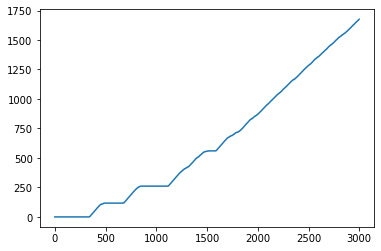

In [21]:
plt.plot(np.cumsum(trainer.mem_total_reward))

(0.0, 3000.0)

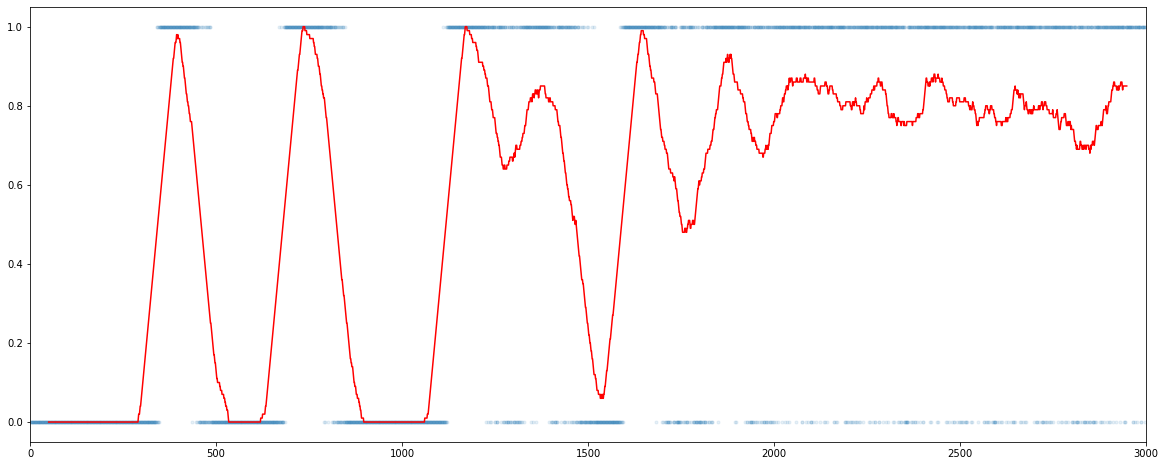

In [22]:
plt.figure(figsize=(20,8))
plt.plot(trainer.mem_total_reward,'.',alpha=.1)
plt.plot(range(50, N-51), np.convolve(trainer.mem_total_reward, np.ones(100)/100)[100:-100], 'r')
plt.xlim(0,N)

(0.0, 3000.0)

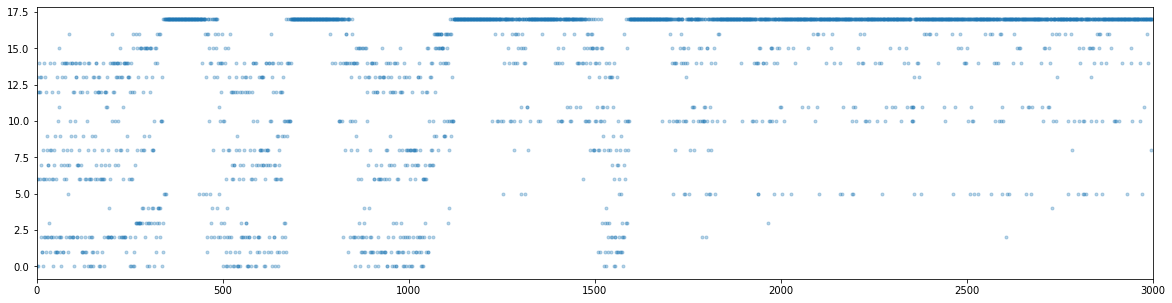

In [23]:
plt.figure(figsize=(20,5)); ax=plt.subplot(111)
ax.plot(trainer.mem_obs_final, '.', alpha=.3)
ax.set_xlim(0,N)

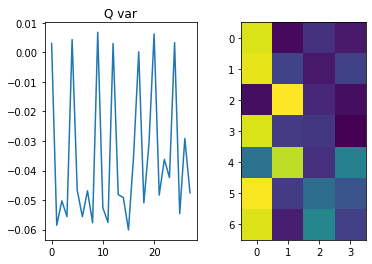

In [24]:
plt.subplot(1,2,1)
plt.plot(agent.Q_var_tab.flatten())
plt.title('Q var')
plt.subplot(1,2,2)
plt.imshow(agent.Q_var_tab[:8,:])

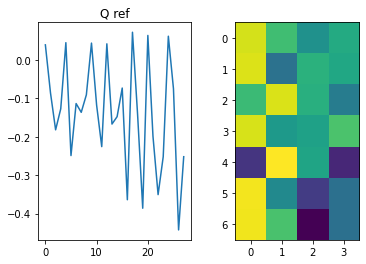

In [25]:
plt.subplot(1,2,1)
plt.plot(agent.Q_ref_tab.flatten())
plt.title('Q ref')
plt.subplot(1,2,2)
plt.imshow(agent.Q_ref_tab[:8,:])

In [26]:
mem_obs_score = np.zeros((env.N_obs, trainer.nb_trials))
mem_p_eff = np.zeros((env.N_obs, trainer.nb_trials))
mem_KL = np.zeros(trainer.nb_trials)
mem_obs_score[trainer.mem_obs_final[0],0] = 1
for t in range(1,trainer.nb_trials):
    obs = trainer.mem_obs_final[t]
    mem_obs_score[:,t] = mem_obs_score[:,t-1] * (1 - args.OBS_LEAK)
    mem_obs_score[obs,t] += 1
    mem_p_eff[:,t] = mem_obs_score[:,t] / np.sum(mem_obs_score[:,t])
    mem_KL[t] = np.log(mem_p_eff[obs,t]) - np.log(trainer.ref_probs[obs])

In [27]:
mem_Q_var_arr = np.array(mem_Q_var)

In [28]:
mem_Q_var_flat = mem_Q_var_arr.reshape((trainer.nb_trials, -1))

(0.0, 3000.0)

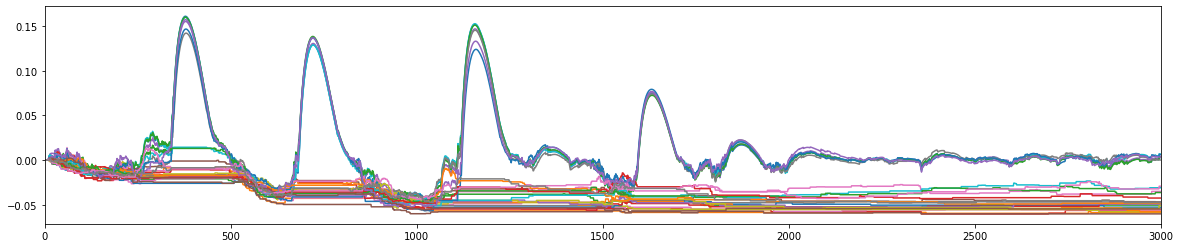

In [29]:
plt.figure(figsize=(20,4)); ax=plt.subplot(111)
ax.plot(mem_Q_var_flat)
ax.set_xlim(0,trainer.nb_trials)

(0.0, 3000.0)

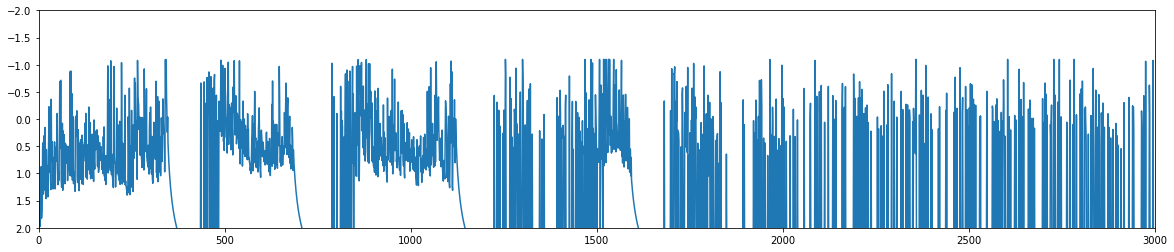

In [30]:
plt.figure(figsize=(20,4))
ax=plt.subplot(111)
ax.plot(mem_KL)
ax.set_ylim(2,-2)
ax.set_xlim(0,trainer.nb_trials)

(0.0, 3000.0)

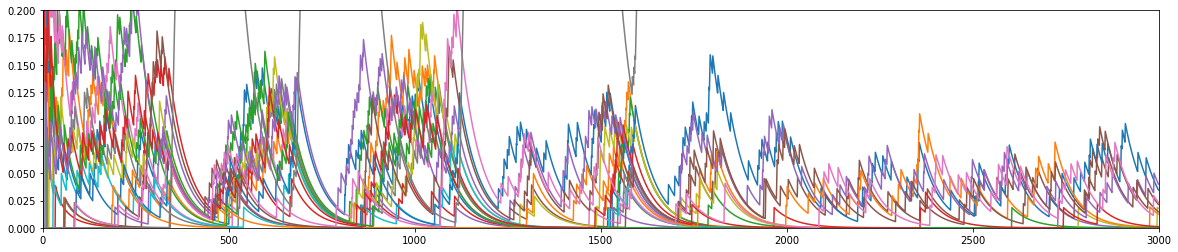

In [31]:
plt.figure(figsize=(20,4))
ax=plt.subplot(111)
ax.plot(mem_p_eff.T)
ax.set_ylim(0,.2)
ax.set_xlim(0,trainer.nb_trials)

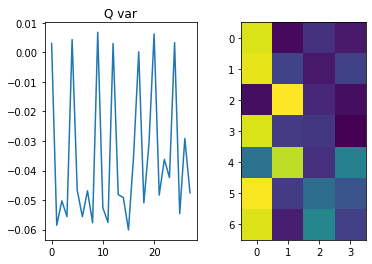

In [32]:
plt.subplot(1,2,1)
plt.plot(agent.Q_var_tab.flatten())
plt.title('Q var')
plt.subplot(1,2,2)
plt.imshow(agent.Q_var_tab)

In [33]:
trial=0
v_min=0
v_max = 0.16
savefigs = False

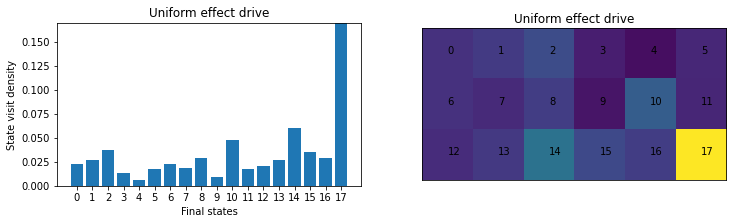

In [34]:
plt.figure(figsize = (12,3))
ax = plt.subplot(1,2,1)
plt.bar(range(env.N_obs), nb_visits_final[trial] / N)
ax.set_xticks(range(18))
plt.xlabel('Final states')
plt.ylabel('State visit density')
plt.ylim([0,0.17])
plt.title('Uniform effect drive')

ax = plt.subplot(1,2,2)
plt.imshow(nb_visits_final[trial].reshape(3,6)/ N, vmin=v_min, vmax=v_max)
for j in range(6):
    for i in range(3):
        plt.text(j,i,6*i+j)

ax.set_xticks([])
ax.set_yticks([])
plt.title('Uniform effect drive')

if savefigs:
    plt.savefig('botteneck-uniform-drive.png', bbox_inches='tight')

In [35]:
trainer.nb_trials

3000

In [36]:
obs_nb_visit = np.zeros((env.N_obs, trainer.nb_trials))
obs_p = np.zeros((env.N_obs, trainer.nb_trials))
for obs in range(env.N_obs):
    obs_nb_visit[obs,:] = np.cumsum(np.array(trainer.mem_obs_final)==obs)
    obs_p[obs,:] = np.cumsum(np.array(trainer.mem_obs_final)==obs) / (np.arange(trainer.nb_trials)+1)
    

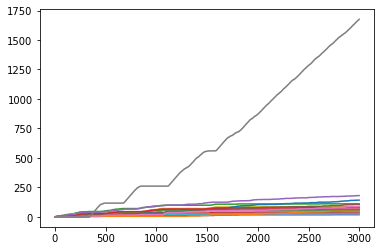

In [37]:
_ = plt.plot(obs_nb_visit.T)

(0.0, 0.2)

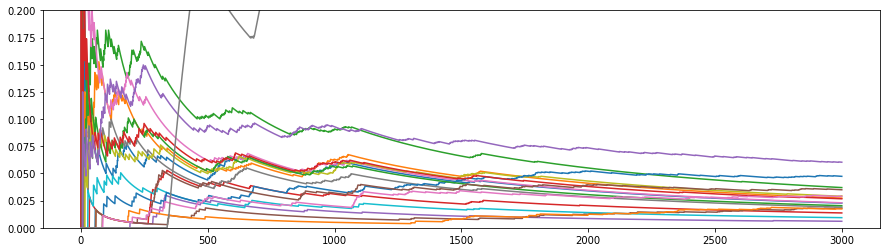

In [38]:
plt.figure(figsize=(15,4))
plt.plot(obs_p.T)
plt.ylim((0,0.2))

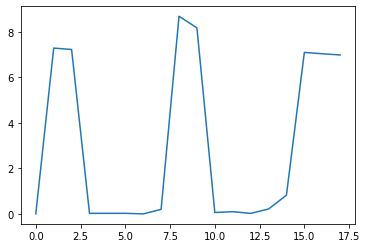

In [39]:
plt.plot(trainer.obs_score)

In [40]:
trainer.ref_probs

array([0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556,
       0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556,
       0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556,
       0.05555556, 0.05555556, 0.05555556])

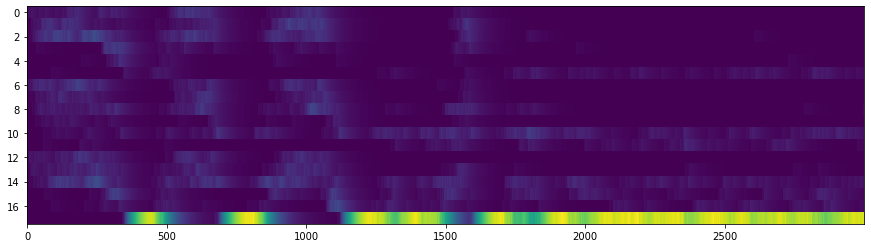

In [41]:
plt.figure(figsize=(15,4))
_ = plt.imshow(mem_obs_score, aspect='auto', interpolation='nearest')

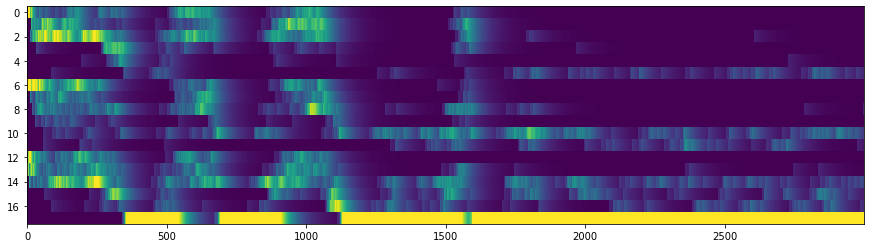

In [42]:
plt.figure(figsize=(15,4))
_ = plt.imshow(mem_p_eff, aspect='auto', interpolation='nearest', vmin=0, vmax=0.2)

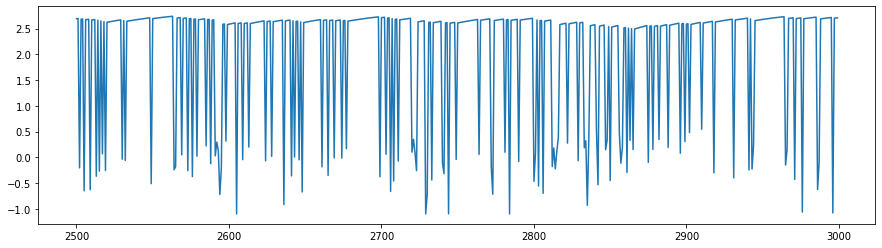

In [43]:
plt.figure(figsize=(15,4))
ax=plt.subplot(111)
ax.plot(range(2500,3000), mem_KL[2500:3000])
#ax.set_ylim(1,-1)
#ax.set_xlim(4500,5000)

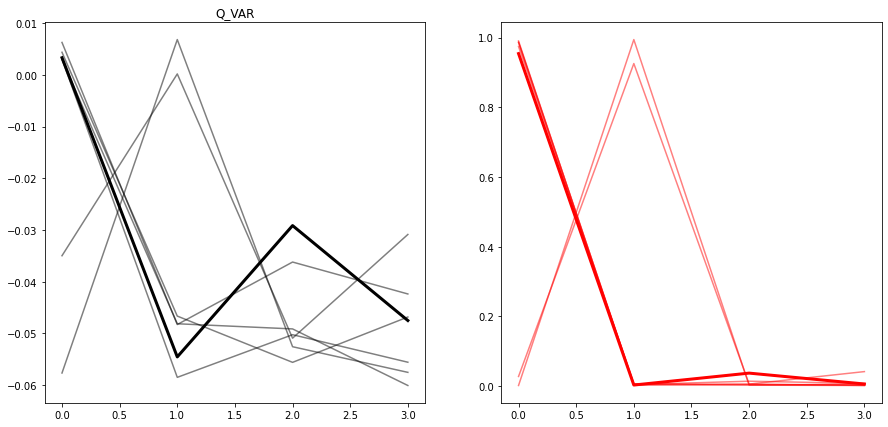

In [44]:
#obs = trainer.agent.get_observation()
plt.figure(figsize=(15,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)
for obs in range(7):
    actions_set = None #trainer.set_actions_set()
    #print(actions_set)
    Q_obs = trainer.agent.set_Q_obs(obs, actions_set = actions_set)
    ax1.plot(Q_obs,'k',alpha=.5)    
    ax1.set_title('Q_VAR') # : MEAN RTG :' + str(m_rtg))
    ax2.plot(agent.softmax(obs, actions_set=actions_set), 'r', alpha=.5)
#ax1.plot((1,trainer.N_PART), (m_rtg, m_rtg), 'r')
ax1.plot(Q_obs,'k',linewidth=3)
ax2.plot(agent.softmax(obs, actions_set=actions_set), 'r', linewidth=3)

## TRIAL

1


Text(0.5, 1.0, 'TRIAL : ACTION')

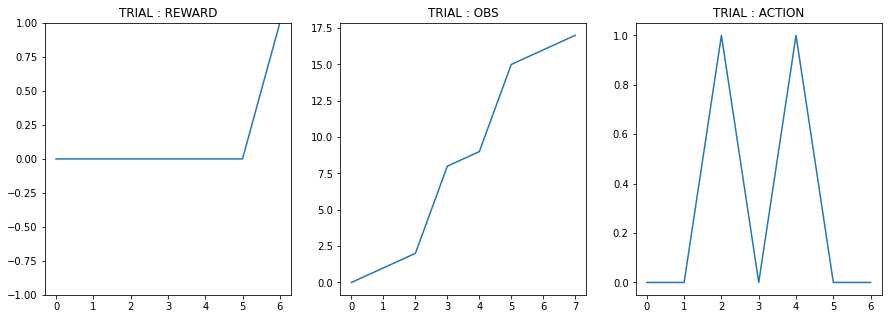

In [45]:
%matplotlib tk
#agent.env=env
trainer.run_episode(render=True)

%matplotlib inline
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(trainer.reward_history)
plt.ylim(-1,1)
plt.title('TRIAL : REWARD')
plt.subplot(1,3,2)
plt.plot(trainer.trajectory)
print(trainer.total_reward)
plt.title('TRIAL : OBS')
plt.subplot(1,3,3)
plt.plot(trainer.action_history)
plt.title('TRIAL : ACTION')
#obs = trainer.agent.get_observation()
